In [24]:
import sys
sys.path.append('../libs')  # Update this path according to the location of your 'dataset' module
import dataset
import preprocessing
import classes
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [25]:
# Chosen Hyper Params

pca_components = 10
svm_cost = 1
svm_kernel = "poly"
scaler_q_min = 25
scaler_q_max = 75

In [26]:
X = dataset.data()
y = np.array(list(map(classes.label_to_class, dataset.labels_array())))

X = X[0:1000]
y = y[0:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, test_size=0.25, random_state=999)

(samples, features, frames) = X_train.shape


In [27]:


# scaler = RobustScaler(quantile_range=(scaler_q_min, scaler_q_max))
# X_transposed = X_train.transpose(0,2,1)
# arr = np.reshape(X_transposed, (samples * frames, features))
# scaled = scaler.fit_transform(arr)

# pca = PCA(n_components=pca_components)
# reduced_X = pca.fit(scaled)

In [28]:
# flat_X = np.empty((samples, frames, pca_components))

# for i in range(samples):
#     flat_X[i] = pca.transform(scaler.transform(X_transposed[i]))

# flat_X = np.reshape(flat_X, (samples, frames * pca_components))
# print(flat_X.shape)

In [29]:
# clf = svm.SVC(cache_size=1000, verbose=True, class_weight='balanced', C = svm_cost, kernel=svm_kernel)
# clf.fit(flat_X, y_train)

In [30]:
# (samples, features, frames) = X_test.shape

# X_test_transposed = X_test.transpose(0,2,1)
# arr = np.reshape(X_test_transposed, (samples * frames, features))
# scaled = scaler.transform(arr)

# reduced_X_test = pca.transform(scaled)

# flat_X_test = np.empty((samples, frames, pca_components))

# for i in range(samples):
#     flat_X_test[i] = pca.transform(scaler.transform(X_test_transposed[i]))

# flat_X_test = np.reshape(flat_X_test, (samples, frames * pca_components))
# print(flat_X_test.shape)

# y_pred = clf.predict(flat_X_test)

In [31]:
# print(y_test[0:10])
# print(y_pred[0:10])
# print(np.array(list(classes.REVERSE_CLASSES.keys())))

# cm = confusion_matrix(y_test, y_pred, labels=np.array(list(classes.REVERSE_CLASSES.keys())))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.CLASSES)
# disp.plot()

In [32]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from skopt import BayesSearchCV
import json


class SVMClassifier(BaseEstimator):
     def __init__(self, pca_components = 10, svm_cost = 1, svm_kernel = "poly", scaler_q = 25):
          self.pca_components = pca_components 
          self.svm_cost = svm_cost 
          self.svm_kernel = svm_kernel
          self.scaler_q = scaler_q

          self.clf = None
          self.scaler = None
          self.pca = None

     def fit(self, X, y):

          (samples, features, frames) = X.shape

          scaler_q_min = self.scaler_q 
          scaler_q_max = 100 - self.scaler_q

          self.scaler = RobustScaler(quantile_range=(scaler_q_min, scaler_q_max))
          X_transposed = X.transpose(0,2,1)
          arr = np.reshape(X_transposed, (samples * frames, features))
          scaled = self.scaler.fit_transform(arr)

          self.pca = PCA(n_components=self.pca_components)
          reduced_X = self.pca.fit(scaled)

          flat_X = np.empty((samples, frames, self.pca_components))

          for i in range(samples):
               flat_X[i] = self.pca.transform(self.scaler.transform(X_transposed[i]))

          flat_X = np.reshape(flat_X, (samples, frames * self.pca_components))

          self.clf = svm.SVC(cache_size=1000, verbose=True, class_weight='balanced', C = self.svm_cost, kernel=self.svm_kernel)
          self.clf.fit(flat_X, y)

          self.is_fitted_ = True
          return self

     def predict(self, X):

          if not self.is_fitted_:
               raise Exception("Not fitted")

          (samples, features, frames) = X.shape

          X_test_transposed = X.transpose(0,2,1)
          arr = np.reshape(X_test_transposed, (samples * frames, features))
          scaled = self.scaler.transform(arr)


          flat_X_test = np.empty((samples, frames, self.pca_components))

          for i in range(samples):
               flat_X_test[i] = self.pca.transform(self.scaler.transform(X_test_transposed[i]))

          flat_X_test = np.reshape(flat_X_test, (samples, frames * self.pca_components))

          y_pred = self.clf.predict(flat_X_test)

          return y_pred

In [33]:
# clf = SVMClassifier()
# clf.fit(X,y)
# y_pred = clf.predict(X_test)

In [34]:
parameters = {
    'svm_cost': [0.5, 1, 5, 10], 
    "pca_components": [7, 10, 15],
    "svm_kernel": ["poly", "rbf"],
    "scaler_q": [25, 15, 5]
}

In [35]:

estimator = SVMClassifier()

bayes = BayesSearchCV(estimator, parameters, n_iter=20, n_jobs=1,scoring="f1_weighted", verbose=True, cv=ShuffleSplit(n_splits=1, test_size=0.2))

bayes.fit(X_train, y_train)

clf = SVMClassifier(**bayes.best_params_)
clf.fit(X_train, y_train)


Fitting 1 folds for each of 1 candidates, totalling 1 fits


[LibSVM]*
optimization finished, #iter = 293
obj = -48.415455, rho = -0.529183
nSV = 256, nBSV = 214
*
optimization finished, #iter = 348
obj = -67.533249, rho = -0.738736
nSV = 315, nBSV = 273
*
optimization finished, #iter = 339
obj = -66.757851, rho = -0.169095
nSV = 320, nBSV = 282
*
optimization finished, #iter = 366
obj = -65.630297, rho = -0.847133
nSV = 318, nBSV = 272
*
optimization finished, #iter = 354
obj = -60.766692, rho = -0.537706
nSV = 302, nBSV = 249
*
optimization finished, #iter = 325
obj = -63.779111, rho = -0.418275
nSV = 299, nBSV = 263
*
optimization finished, #iter = 318
obj = -54.576654, rho = -0.740724
nSV = 273, nBSV = 220
*
optimization finished, #iter = 299
obj = -47.427938, rho = -0.312440
nSV = 242, nBSV = 183
*
optimization finished, #iter = 362
obj = -69.670566, rho = -0.847720
nSV = 323, nBSV = 276
*.*
optimization finished, #iter = 391
obj = -81.296417, rho = -0.893336
nSV = 350, nBSV = 311
.*
optimization finished, #iter = 91
obj = -29.164447, rho =

SVMClassifier(pca_components=15, svm_cost=5, svm_kernel='rbf')

In [36]:
y_pred = clf.predict(X_test)

print(clf.get_params())

with open('svm_params.txt', 'w') as file:
     file.write(str(f1_score(y_test, y_pred, average='weighted')))
     file.write("\n")
     file.write(json.dumps(clf.get_params()))

{'pca_components': 15, 'scaler_q': 25, 'svm_cost': 5, 'svm_kernel': 'rbf'}


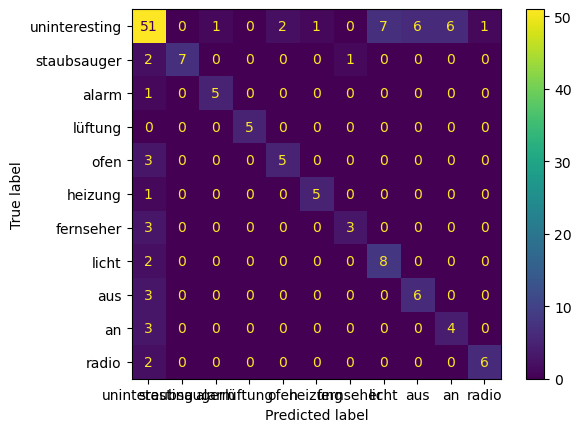

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=np.array(list(classes.REVERSE_CLASSES.keys())))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.CLASSES)
disp.plot()